#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импорты

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge
from lightgbm.sklearn import LGBMRegressor

/usr/lib/python3/dist-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/lib/python3/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/lib/python3/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/lib/python3/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _

### Загрузка данных

In [2]:
df = pd.read_csv("taxi.csv", index_col=[0], parse_dates=[0])

### Проверка загрузки

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные успешно загружены.

### Сортировка индексов

In [5]:
df = df.sort_index()

### Проверка на монотонность

In [6]:
df.index.is_monotonic

<ipython-input-6-d1f11a250a74>:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  df.index.is_monotonic


True

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Индекс монотонный. Данные записаны с 1 марта 2018 года по 31 августа 2018 года с шагом в 10 минут.

### Проверка на пропуски

In [9]:
df.isna().sum()

num_orders    0
dtype: int64

Пропусков нет.

### Ресемплинг

Так как мы имеем дело с количеством заказов для ресемплинга нужно использовать суммирование.

In [10]:
df = df.resample("1H").sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

### Описательная статистика

In [12]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Cреднее количестов заказов 84, медианное - 78.

### KDE

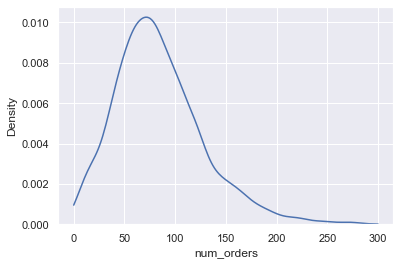

In [13]:
sns.set(rc={'figure.figsize':(15, 9)})
sns.kdeplot(df.iloc[:,0], clip=(0.0, 300));

Больше похоже на распределение Пуассона.

### Общий график

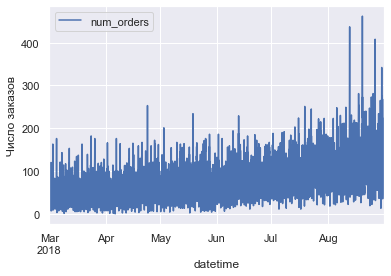

In [14]:
df.plot(ylabel="Число заказов");

Без декомпозиции видно, что среднее число заказов растёт.

### Скользящее среднее за сутки

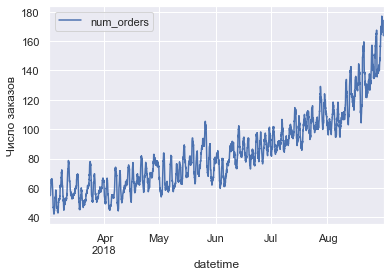

In [15]:
df.rolling(24).mean().dropna().plot(ylabel="Число заказов");

Общая тенденция к росту числа заказов стала ещё очевиднее.

### Декомпозиция

#### По дням

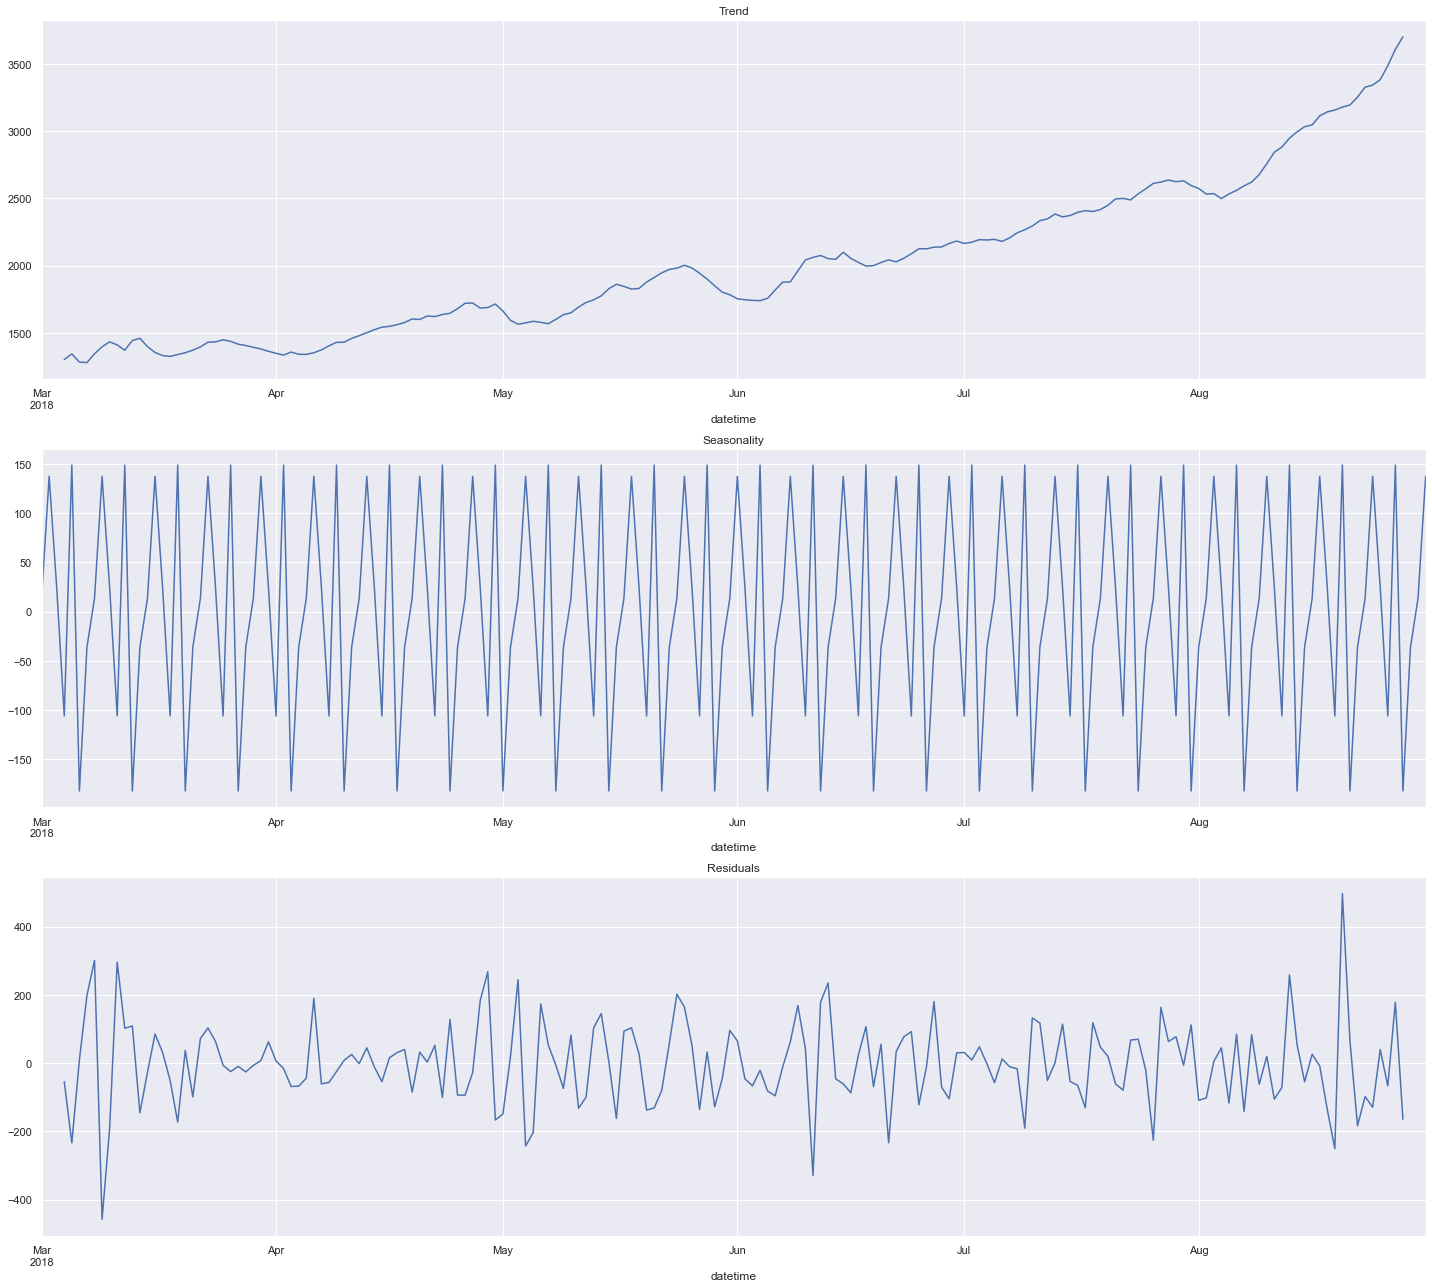

In [16]:
decomposed = seasonal_decompose(df.resample("1D").sum()) 
plt.figure(figsize=(20, 18))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видна недельная сезонность.

#### Сутки

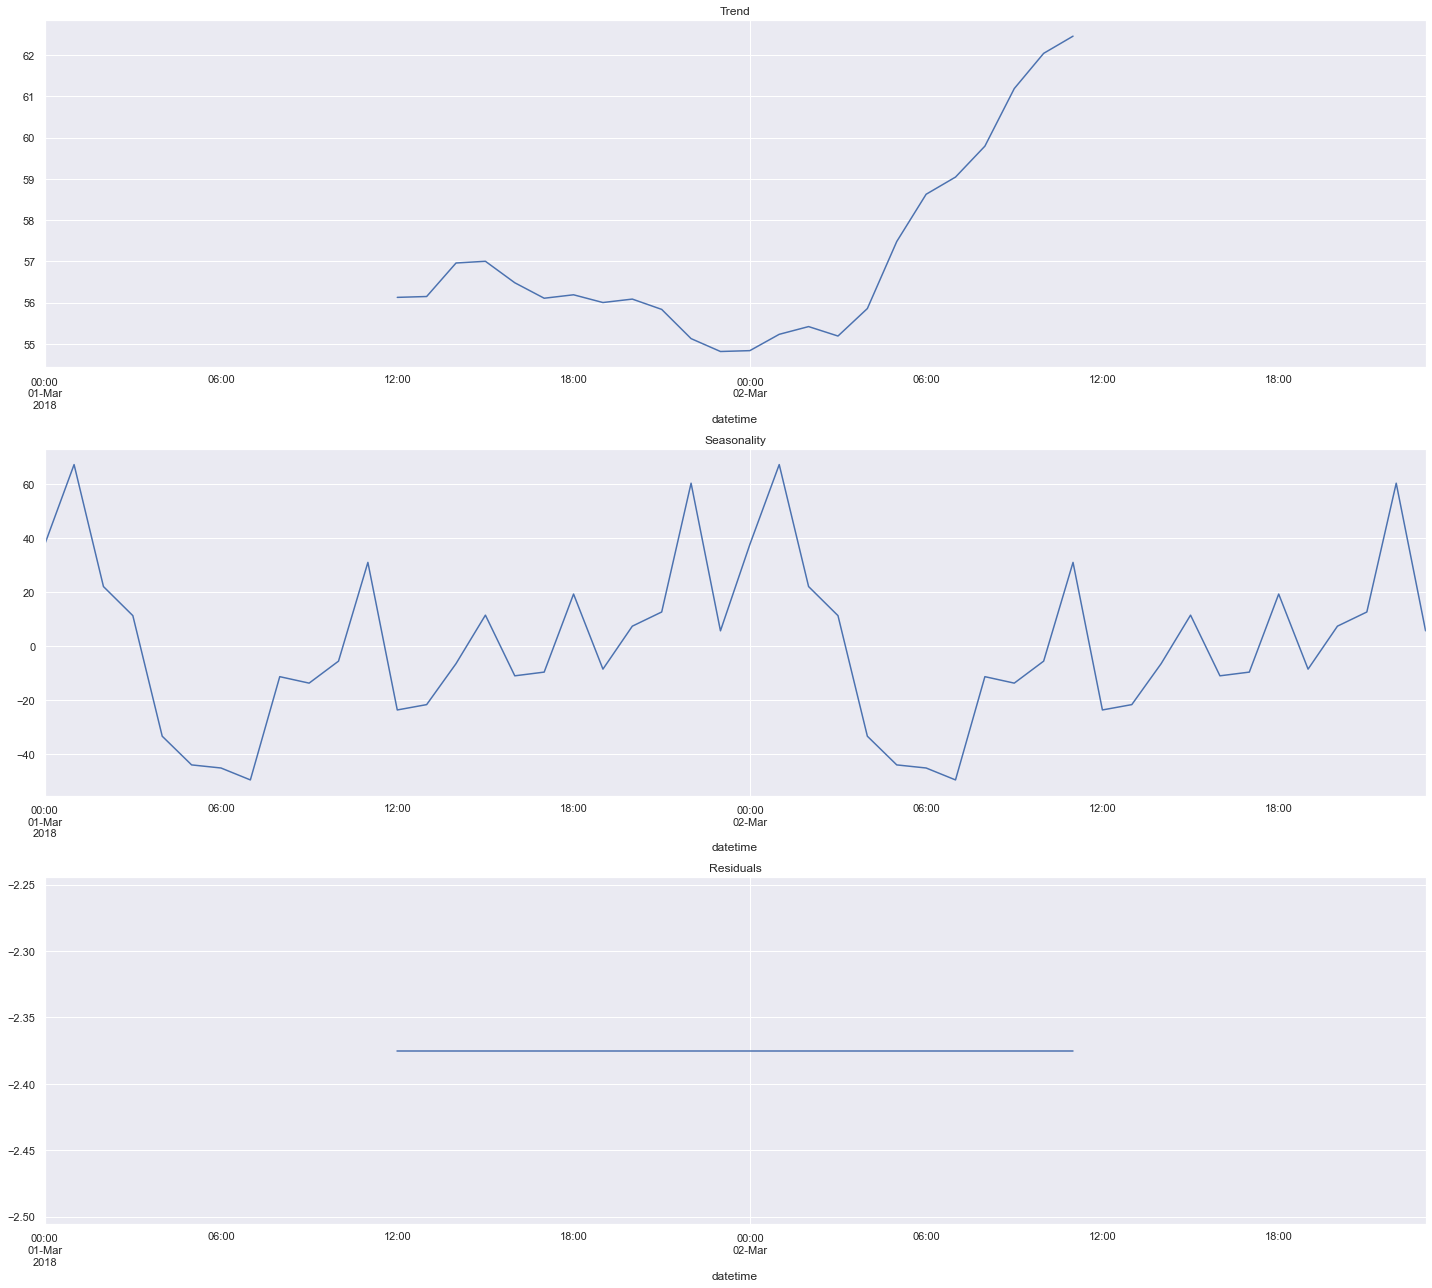

In [17]:
decomposed = seasonal_decompose(df.iloc[0:48]) 
plt.figure(figsize=(20, 18))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Суточная сезонность тоже заметна.

## Обучение

### Создадим признаки

In [18]:
def make_features(data, max_lag, step_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(step_lag, max_lag + 1, step_lag):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [19]:
make_features(df, 160, 8,  48)
df.head()

,num_orders,day,dayofweek,hour,lag_8,lag_16,lag_24,lag_32,lag_40,lag_48,...,lag_96,lag_104,lag_112,lag_120,lag_128,lag_136,lag_144,lag_152,lag_160,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Разделение выборки на обучающую и тестовую

In [20]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

### Разделение на предикторы и отклик

In [21]:
test_X = test.drop("num_orders", axis=1)
test_y = test["num_orders"]
train_X = train.drop("num_orders", axis=1)
train_y = train["num_orders"]

#### Линейные модели

##### Линейная регрессия

Будем использовать кросс-валидацию со специальным вариантом сплита для временных рядов.

In [22]:
rmse_scorer = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False)
tscv = TimeSeriesSplit()
lr = LinearRegression()
rmse = cross_val_score(lr,train_X, train_y, cv=tscv, scoring=rmse_scorer).mean()
print("RMSE=", round(abs(rmse), 1))

RMSE= 24.2


В качестве базовой модели неплохо.

##### Гребневая регрессия

Будем подбирать гиперпараметр - степень регуляризации.

In [23]:
SEED = 12345
ridge = Ridge(random_state=SEED)
params = {"alpha":np.logspace(-5, 5, 20)}
gscv_ridge = GridSearchCV(ridge, params, cv=tscv, scoring=rmse_scorer, verbose=3, n_jobs=-1)
gscv_ridge.fit(train_X, train_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(random_state=12345), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])},
             scoring=make_scorer(<lambda>, greater_is_better=False), verbose=3)

In [24]:
best_ridge_cv_rmse = abs(gscv_ridge.best_score_)
best_ridge_alpha = gscv_ridge.best_params_["alpha"]
best_ridge = gscv_ridge.best_estimator_
print(f"RMSE (cv) for best ridge model = {best_ridge_cv_rmse:.1f} for Alpha = {best_ridge_alpha}")

RMSE (cv) for best ridge model = 24.1 for Alpha = 100000.0


Регуляризация не сильно помогла.

### Градиентный бустинг

In [25]:
gb = LGBMRegressor(random_state=SEED)
params = {"num_leaves":[20, 30, 40], 'learning_rate':[0.01, 0.1, 1.0]}
gscv_gb = GridSearchCV(gb, params, cv=tscv, scoring=rmse_scorer, verbose=3, n_jobs=-1)
gscv_gb.fit(train_X, train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1.0],
                         'num_leaves': [20, 30, 40]},
             scoring=make_scorer(<lambda>, greater_is_better=False), verbose=3)

In [26]:
best_gb_cv_rmse = abs(gscv_gb.best_score_)
best_gb_nl = gscv_gb.best_params_["num_leaves"]
best_gb_lr = gscv_gb.best_params_["learning_rate"]
best_gb = gscv_gb.best_estimator_
print(f"RMSE (cv) for best GB model = {best_gb_cv_rmse:.1f} for No. leaves = {best_gb_nl}, Learning Rate = {best_gb_lr}")

RMSE (cv) for best GB model = 24.8 for No. leaves = 20, Learning Rate = 0.1


Странно, что это хуже, чем линейные модели.

## Тестирование

### Базовые линии

#### По среднему

In [27]:
pred_mean = np.ones(test_y.shape) * train_y.mean()
print("RMSE:", round(mean_squared_error(test_y, pred_mean, squared=False), 1))

RMSE: 84.0


#### По предыдущнму

In [28]:
pred_previous = test_y.shift()
pred_previous.iloc[0] = train_y.iloc[-1] 
print("RMSE:", round(mean_squared_error(test_y, pred_previous, squared=False), 1))

RMSE: 58.9


Если учесть суточную сезнонность.

In [29]:
pred_previous = test_y.shift(24)
pred_previous.isna().sum()
pred_previous.iloc[0:24] = train_y.iloc[-24:] 
print("RMSE:", round(mean_squared_error(test_y, pred_previous, squared=False), 1))

RMSE: 57.2


Меньше, чем просто по предыдущему.

Учитывая недельную сезонность.

In [30]:
pred_previous = test_y.shift(24*7)
pred_previous.isna().sum()
pred_previous.iloc[0:24*7] = train_y.iloc[-24*7:] 
print("RMSE:", round(mean_squared_error(test_y, pred_previous, squared=False), 1))

RMSE: 39.5


Ха, тут для предсказания, с достаточной точностью и модель не особо нужна :-)

### Тестирование модели

In [31]:
y_pred = best_ridge.predict(test_X)
gb_test_rmse = mean_squared_error(test_y, y_pred, squared=False)
print(f"RMSE (test) for Ridge model = {gb_test_rmse:.1f}")

RMSE (test) for Ridge model = 41.5


Тем не менее, гребневая регрессия показывает результат, достаточный для сдачи проекта.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48